# When do the biggest fish bite?

You're an avid fisher. In the past year, you caught exactly $N = 1000$ fish and to celebrate the achievement you've decided to develop a statistical model that relates the weight $x$ of the fish to the time of day when you caught it. Specifically, each time you caught a fish you recorded the UNIX timestamp of that event into an array $T$, and its weight in grams into an array $X$. You want to regress fish weight on time of day caught, given the data $T, X$ you captured.

Develop a model that takes a timestamp as input, and returns the expected weight of a fish caught at that timestamp. Use whatever techniques you think are appropriate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Make data

In [2]:
def make_data():
    t0 = 1649730445 # April 10, 2022, 2:27:25 GMT
    N = 1000
    T = np.random.uniform(t0, t0 + 365*24*3600, N)
    Tday = T % (24*3600)
    Tsin = np.sin(2*np.pi*Tday / (24*3600))
    Tcos = np.cos(2*np.pi*Tday / (24*3600))
    Tcos3 = np.cos(3*2*np.pi*Tday / (24*3600))

    X = 50*Tsin + 620*Tcos + 121*Tcos3
    X -= -100 + np.min(X)
    X *= np.random.normal(1, 0.1, N)**2
    X -= -123.4 + np.min(X)
    return T, X

### Solution

In [3]:
T, X = make_data()

The question asks about time of day, so:

In [4]:
Tday = T % (24*3600)

(0.0, 2355.0820565787913)

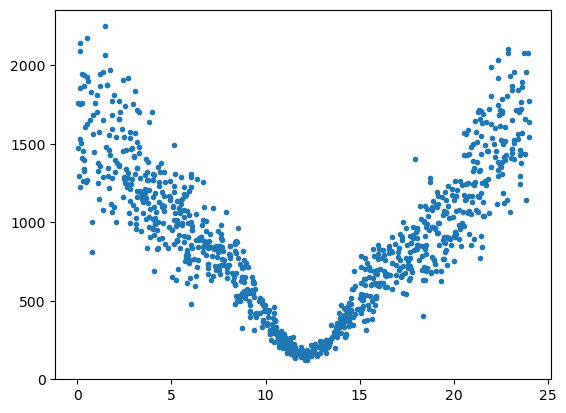

In [5]:
plt.plot(Tday/3600, X, ".")
plt.ylim((0, None))

It looks like fish caught aroung midnight GMT definitely tend to be heavier. But how do you arrange the data to make 0:01 close to 23:58?

One way is to use the unit circle:

In [6]:
Tsin = np.sin(2*np.pi*Tday / (24*3600))
Tcos = np.cos(2*np.pi*Tday / (24*3600))

In `Tsin, Tcos` coordinates, 0:01 is close to 23:58, even though they are far in terms of `T`.

Next, we can try a linear model, with `Tsin, Tcos` as features (it doesn't make sense to use plain `T` for that -- why?):

In [7]:
Tmat = np.stack((Tsin, Tcos, np.ones(len(X)))).T
a = np.linalg.lstsq(Tmat, X, rcond=None)[0]

In [8]:
a

array([ 48.53945103, 623.01421553, 902.64237972])

See how it stacks up:

In [9]:
Xpred = Tmat @ a

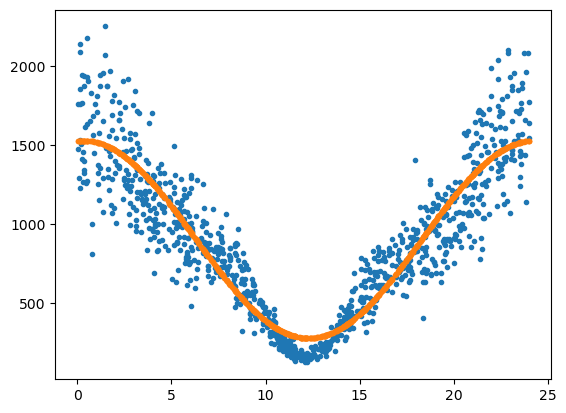

In [10]:
plt.plot(Tday/3600, X, ".")
plt.plot(Tday/3600, Xpred, ".")

Pretty good, definitely good enough to use, but not perfect. The basic linear model not quite expressive enough, so there is some bias. The question asked for a function that takes a timestamp and returns an expected weight, so:

In [11]:
def e_fish_weight(t):
    tday = t % (24*3600)
    tsin = np.sin(2*np.pi*tday / (24*3600))
    tcos = np.cos(2*np.pi*tday / (24*3600))
    return [tsin, tcos, 1] @ a

In [13]:
e_fish_weight(1234.5) # expected weight of fish caught at 12:20 am GMT (in 1970)

1527.4994490353279

### Alternative to linear regression

You can also use a nonparametric method with `Tsin` and `Tcos`. For example, k-nearest neighbors:

In [14]:
Tsin_cos = Tmat[:, :2]
distances = np.array([
    [np.linalg.norm(Tsin_cos[i] - Tsin_cos[j])
     for j in range(len(X))]
    for i in range(len(X))
])

In [15]:
nn = np.argsort(distances, axis=1)

In [16]:
k = 20
knn_X = np.mean(X[nn[:, 1:1+k]], axis=1)

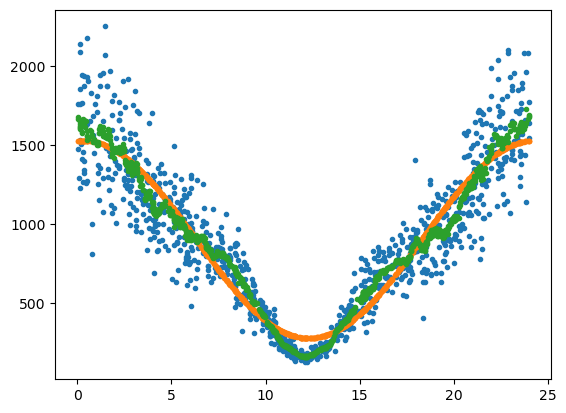

In [17]:
plt.plot(Tday/3600, X, ".")
plt.plot(Tday/3600, Xpred, ".")
plt.plot(Tday/3600, knn_X, ".")

kNN has less bias and more variance, as expected.

(kernel density estimation would also be a good technique here; you'd want to use a kernel that respects the daily period instead of a standard Gaussian or similar)